In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [39]:
df = pd.read_csv('data/LoadData.csv')
df.head()

,Date,N_Y_C_
0,05/01/2007 00:00:00,4854.400000
1,05/01/2007 00:15:00,4777.370779
2,05/01/2007 00:30:00,4729.483400
3,05/01/2007 00:45:00,4682.387550
4,05/01/2007 01:00:00,4587.337550


In [40]:
# Creating train and test set
# Index 379877 marks the start of March 2018
# train = df[:379876]
# test = df[379877:]

# Aggregating the dataset at daily level
df['Timestamp'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M:%S')
df.index = df['Timestamp']
df = df.resample('D').mean()
print(df)

# train['Timestamp'] = pd.to_datetime(train['Date'], format='%m/%d/%Y %H:%M:%S')
# train.index = train['Timestamp']
# train = train.resample('D').mean()

# test['Timestamp'] = pd.to_datetime(test['Date'], format='%m/%d/%Y %H:%M:%S')
# test.index = test['Timestamp']
# test = test.resample('D').mean()

# Plotting data
# train.N_Y_C_.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
# test.N_Y_C_.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
# plt.show()

                 N_Y_C_
Timestamp              
2007-05-01  5666.252902
2007-05-02  5666.180415
2007-05-03  5662.574479
2007-05-04  5615.351488
2007-05-05  5032.153638
...                 ...
2019-02-24  5144.902344
2019-02-25  5790.148177
2019-02-26  6000.704688
2019-02-27  6114.133594
2019-02-28  5978.750781

[4322 rows x 1 columns]


In [41]:
# smooth the graph
df_mean = df.N_Y_C_.rolling(window=30).mean()
# train_mean = train.N_Y_C_.rolling(window=30).mean()
# test_mean = test.N_Y_C_.rolling(window=30).mean()
# train_mean.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
# test_mean.plot(figsize=(15, 8), title='Daily N_Y_C_', fontsize=14)
plt.show()

[[5831.71163151]
 [5887.61672434]
 [5945.97393753]
 ...
 [5803.44386285]
 [5805.68490451]
 [5801.13641493]]


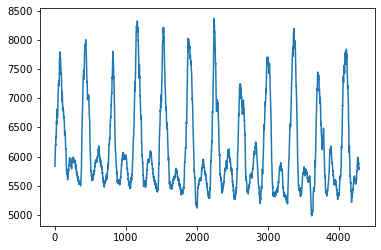

In [42]:
# training_set = pd.read_csv('data/LoadData.csv')
# training_set = training_set.iloc[:,1:2].values
training_set = df_mean.dropna()
trans = [i for i in training_set.values]
training_set = np.array(trans).reshape(len(trans), 1)
print(training_set)


plt.plot(training_set, label = 'Electricity Consumption Data')
plt.show()

In [43]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [44]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [45]:
num_epochs = 100000
learning_rate = 0.01

# x 的特征维度
input_size = 1
# 隐藏层的特征维度
hidden_size = 2
# lstm隐层的层数，默认为1
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.40128
Epoch: 100, loss: 0.04817
Epoch: 200, loss: 0.04413
Epoch: 300, loss: 0.04303
Epoch: 400, loss: 0.04196
Epoch: 500, loss: 0.04089
Epoch: 600, loss: 0.03980
Epoch: 700, loss: 0.03870
Epoch: 800, loss: 0.03756
Epoch: 900, loss: 0.03638
Epoch: 1000, loss: 0.03516
Epoch: 1100, loss: 0.03388
Epoch: 1200, loss: 0.03255
Epoch: 1300, loss: 0.03116
Epoch: 1400, loss: 0.02971
Epoch: 1500, loss: 0.02819
Epoch: 1600, loss: 0.02662
Epoch: 1700, loss: 0.02500
Epoch: 1800, loss: 0.02333
Epoch: 1900, loss: 0.02163
Epoch: 2000, loss: 0.01990
Epoch: 2100, loss: 0.01818
Epoch: 2200, loss: 0.01646
Epoch: 2300, loss: 0.01478
Epoch: 2400, loss: 0.01315
Epoch: 2500, loss: 0.01159
Epoch: 2600, loss: 0.01011
Epoch: 2700, loss: 0.00874
Epoch: 2800, loss: 0.00748
Epoch: 2900, loss: 0.00634
Epoch: 3000, loss: 0.00533
Epoch: 3100, loss: 0.00444
Epoch: 3200, loss: 0.00366
Epoch: 3300, loss: 0.00301
Epoch: 3400, loss: 0.00245
Epoch: 3500, loss: 0.00200
Epoch: 3600, loss: 0.00162
Epoch: 3700, 

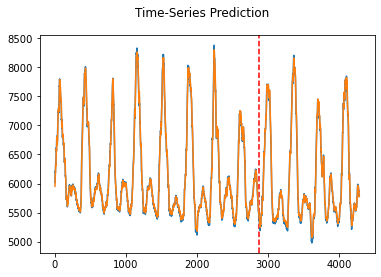

In [46]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()